## Homework 5.1
 A bigram is the combination of words.  Find the 10 most common bigrams from the text.  Order counts in the bigram combination for example "in the" is not the same bigram as "the in"



**Bigrams using NLTK**

In [34]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
import itertools
from functools import reduce
import re

 
fname = 'data/canterbury/alice29.txt'
with open(fname) as f:
    content = f.readlines()

    
#the readlines is to read into an array of 1 element. So content[0] returns the first element which is our text 
content = content[0]
all_bigrams = []
Total_num_of_bigrams = 0

for line in content.split("\r"):
    #Strip all special characters except alphanumeric and space
    line = re.sub (r'([^a-zA-Z0-9 ]+?)', '', line)
    
    tokens = nltk.word_tokenize(line)    
    bigrams = ngrams(tokens,2)
    all_bigrams.append(list(bigrams))   

# Convert nested array into a flattened 1-dimensional array
flat_list_bigrams = [item for sublist in all_bigrams for item in sublist]

# total number of bigrams
Total_num_of_bigrams = len(flat_list_bigrams)
print("Total Number of Bigrams:")
print(Total_num_of_bigrams)

# To pull out the count of each bigram 
top_list_bigrams = Counter(flat_list_bigrams)

print "Top 10 Bigrams"

# To print the top 10 most common bigrams
top_list_bigrams.most_common(10) 


Total Number of Bigrams:
23675
Top 10 Bigrams


[(('said', 'the'), 203),
 (('of', 'the'), 122),
 (('said', 'Alice'), 110),
 (('in', 'a'), 93),
 (('and', 'the'), 71),
 (('in', 'the'), 71),
 (('to', 'the'), 65),
 (('at', 'the'), 57),
 (('it', 'was'), 56),
 (('as', 'she'), 54)]

**References:**

    https://stackoverflow.com/questions/32441605/generating-ngrams-unigrams-bigrams-etc-from-a-large-corpus-of-txt-files-and-t/32442106
    

**Bigrams using Mrjob, Map-Combine-Reduce**

In [8]:
%%writefile code/HW5bigram1.py
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
from itertools import islice, izip
import itertools
import heapq

f = re.compile(r'[a-zA-Z]+')
TOP10 = 10

class BigramCount(MRJob): 
    def mapFun(self, _, line):
        words = f.findall(line)
        for i in izip(words, islice(words, 1, None)):
            bigram =(i[0]+" " +i[1])
            yield bigram, 1 
    def combineFun(self, bigram, counts):
        yield bigram, sum(counts) 
    def reduceFun(self, bigram, counts):
        yield bigram,sum(counts) 
    def top10_mapper(self, bigram, counts):
        yield "Top " + str(TOP10), (counts, bigram) 
    def top10_reducer(self, _, countsAndBigrams):
        for countsAndbigrams in heapq.nlargest(TOP10, countsAndBigrams):
            global TOP10
            output = (TOP10, countsAndbigrams)
            TOP10 = TOP10 - 1    
            yield output
            

    def steps(self):
        return [
            MRStep(mapper=self.mapFun,
                   combiner=self.combineFun,
                   reducer=self.reduceFun),
            MRStep(mapper=self.top10_mapper,
                   reducer=self.top10_reducer)
        ]


if __name__ == '__main__':
    BigramCount.run()

Overwriting code/HW5bigram1.py


**References:**
    
    https://stackoverflow.com/questions/14168601/nltk-makes-it-easy-to-compute-bigrams-of-words-what-about-letters
    https://stackoverflow.com/questions/45183393/use-mrjob-to-count-bigram-accur-type-error
        
    

In [9]:
%run code/HW5bigram1.py data/canterbury/alice29.txt

/Users/rashmimahesh/Desktop/MyPython/HW5/code/HW5bigram1.py:26: SyntaxWarning: name 'TOP10' is used prior to global declaration
  global TOP10
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs specified for inline runner
No configs specified for inline runner
Running step 1 of 2...
Running step 1 of 2...
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291
Running step 2 of 2...
Running step 2 of 2...
job output is in /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291/output
job output is in /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291/output
Streaming final output from /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.

10	[207, "said the"]
9	[129, "of the"]
8	[116, "said Alice"]
7	[95, "in a"]
6	[77, "in the"]
5	[76, "and the"]
4	[69, "to the"]
3	[62, "the Queen"]
2	[60, "it was"]
1	[59, "at the"]


Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram1.rashmimahesh.20181016.023205.632291...


## Homework 5.2
Now do the same analysis but make the word order not count "in the" == "the in".  Find the 10 most common ordered bigrams from the alice text.  

In [10]:
%%writefile code/HW5bigram2.py
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
from itertools import islice, izip
import itertools
import heapq

f = re.compile(r'[a-zA-Z]+')
TOP10 = 10

class BigramCount(MRJob): 
    def mapFun(self, _, line):
        words = f.findall(line)
        for i in izip(words, islice(words, 1, None)):
            bigram =(i[0],i[1])
            sort_bigram = sorted(bigram)
            yield sort_bigram, 1 
    def combineFun(self, bigram, counts):
        yield bigram, sum(counts) 
    def reduceFun(self, bigram, counts):
        yield bigram,sum(counts) 
    def top10_mapper(self, bigram, counts):
        yield "Top " + str(TOP10), (counts, bigram) 
    def top10_reducer(self, _, countsAndBigrams):
        for countsAndbigrams in heapq.nlargest(TOP10, countsAndBigrams):
            global TOP10
            output = (TOP10, countsAndbigrams)
            TOP10 = TOP10 - 1    
            yield output
            

    def steps(self):
        return [
            MRStep(mapper=self.mapFun,
                   combiner=self.combineFun,
                   reducer=self.reduceFun),
            MRStep(mapper=self.top10_mapper,
                   reducer=self.top10_reducer)
        ]


if __name__ == '__main__':
    BigramCount.run()

Writing code/HW5bigram2.py


In [11]:
%run code/HW5bigram2.py data/canterbury/alice29.txt

/Users/rashmimahesh/Desktop/MyPython/HW5/code/HW5bigram2.py:27: SyntaxWarning: name 'TOP10' is used prior to global declaration
  global TOP10
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
Running step 1 of 2...
Running step 1 of 2...
Running step 1 of 2...
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442
Running step 2 of 2...
Running step 2 of 2...
Running step 2 of 2...
job output is in /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmi

10	[207, ["said", "the"]]
9	[129, ["of", "the"]]
8	[127, ["Alice", "said"]]
7	[95, ["a", "in"]]
6	[77, ["in", "the"]]
5	[76, ["and", "the"]]
4	[69, ["the", "to"]]
3	[63, ["Queen", "the"]]
2	[61, ["it", "was"]]
1	[59, ["at", "the"]]


Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram2.rashmimahesh.20181016.023553.285442...


## Homework 5.3
A trigram are three word combintation.  Find the 10 most common ordered trigrams from the alice text.  Make it so that the order of the words do not count in the trigram combination for example "in the air" is the same trigram as "the air in" or "air in the"...


**Trigrams using NLTK**

In [30]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
import itertools
from functools import reduce
import re


fname = 'data/canterbury/alice29.txt'
with open(fname) as f:
    content = f.readlines()

#the readlines is read into an array of 1 element. So content[0] returns the first element which is our text    
content = content[0]
all_trigrams = []
Total_num_of_trigrams = 0

for line in content.split("\r"):
    #Strip all special characters except alphanumeric and space
    line = re.sub (r'([^a-zA-Z0-9 ]+?)', '', line)
    tokens = nltk.word_tokenize(line)    
    trigrams = ngrams(tokens,3)
    all_trigrams.append(list(trigrams))   

# Convert nested array into a flattened 1-dimensional array 
flat_list_trigrams = [item for sublist in all_trigrams for item in sublist]

# total number of trigrams
Total_num_of_trigrams = len(flat_list_trigrams)
print("Total Number of Trigrams:")
print(Total_num_of_trigrams)

# To pull out the count of each trigram 
top_list_trigrams = Counter(flat_list_trigrams)

print "Top 10 Trigrams"

# To print the top 10 most common trigrams
top_list_trigrams.most_common(10) 


Total Number of Trigrams:
21059
Top 10 Trigrams


[(('the', 'Mock', 'Turtle'), 44),
 (('said', 'the', 'King'), 29),
 (('the', 'March', 'Hare'), 27),
 (('said', 'the', 'Hatter'), 21),
 (('the', 'White', 'Rabbit'), 20),
 (('said', 'to', 'herself'), 18),
 (('said', 'the', 'Caterpillar'), 18),
 (('said', 'the', 'Mock'), 18),
 (('she', 'said', 'to'), 16),
 (('said', 'the', 'Duchess'), 15)]

**Bigrams using Mrjob, Map-Combine-Reduce**

In [14]:
%%writefile code/HW5bigram3.py
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
import re
from itertools import islice, izip
import itertools
import heapq

f = re.compile(r'[a-zA-Z]+')
TOP10 = 10

class BigramCount(MRJob): 
    def mapFun(self, _, line):
        words = f.findall(line)
        for i in izip(words, islice(words, 1, None),islice(words,2,None)):
            trigram =(i[0],i[1],i[2])
            sort_trigram = sorted(trigram)
            yield sort_trigram, 1 
    def combineFun(self, trigram, counts):
        yield trigram, sum(counts) 
    def reduceFun(self, trigram, counts):
        yield trigram,sum(counts) 
    def top10_mapper(self, trigram, counts):
        yield "Top " + str(TOP10), (counts, trigram) 
    def top10_reducer(self, _, countsAndTrigrams):
        for countsAndTrigrams in heapq.nlargest(TOP10, countsAndTrigrams):
            global TOP10
            output = (TOP10, countsAndTrigrams)
            TOP10 = TOP10 - 1    
            yield output
            

    def steps(self):
        return [
            MRStep(mapper=self.mapFun,
                   combiner=self.combineFun,
                   reducer=self.reduceFun),
            MRStep(mapper=self.top10_mapper,
                   reducer=self.top10_reducer)
        ]


if __name__ == '__main__':
    BigramCount.run()

Overwriting code/HW5bigram3.py


In [15]:
%run code/HW5bigram3.py data/canterbury/alice29.txt

/Users/rashmimahesh/Desktop/MyPython/HW5/code/HW5bigram3.py:27: SyntaxWarning: name 'TOP10' is used prior to global declaration
  global TOP10
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs found; falling back on auto-configuration
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
No configs specified for inline runner
Running step 1 of 2...
Running step 1 of 2...
Running step 1 of 2...
Running step 1 of 2...
Running step 1 of 2...
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468
Creating temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468
Creating temp directory /var/folders/54/s4

10	[49, ["Mock", "Turtle", "the"]]
9	[37, ["King", "said", "the"]]
8	[30, ["I", "don", "t"]]
7	[29, ["Hare", "March", "the"]]
6	[24, ["t", "won", "you"]]
5	[23, ["Hatter", "said", "the"]]
4	[20, ["Rabbit", "White", "the"]]
3	[19, ["herself", "said", "to"]]
2	[19, ["Mock", "said", "the"]]
1	[19, ["Gryphon", "said", "the"]]


Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468...
Removing temp directory /var/folders/54/s4nndgq53ml0qj_q2pqp8hhm0000gp/T/HW5bigram3.rashmimahesh.20181016.024325.685468...


## Homework 5.4
Create graphs to explain the relationship of the frequency of monograms ( words ) to bigrams and trigam frequencies

In [31]:
import nltk
from nltk import word_tokenize
from nltk.util import ngrams
from collections import Counter
import itertools
from functools import reduce
import re

Total_Num_of_monograms = 0
fname = 'data/canterbury/alice29.txt'
with open(fname, 'r') as f:
    for line in f:
        words = line.split()
        Total_Num_of_monograms = len(words)
print("Number of Monograms:")
print(Total_Num_of_monograms)

Number of Monograms:
26458


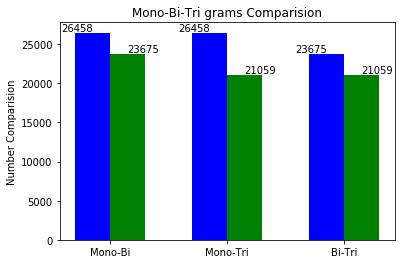

In [67]:
import numpy as np
import matplotlib.pyplot as plt

mono = (26458, 26458,23675)
biTri = (23675, 21059, 21059)

ind = np.arange(len(mono))  
width = 0.3

fig, ax = plt.subplots()
rects1 = ax.bar(ind - width/2, mono, width,
                color='blue', label='Monogram')
rects2 = ax.bar(ind + width/2, biTri, width,
                color='green', label='BiTrigram')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Number Comparision')
ax.set_title('Mono-Bi-Tri grams Comparision')
ax.set_xticks(ind)
ax.set_xticklabels(('Mono-Bi', 'Mono-Tri', 'Bi-Tri'))


def autolabel(rects, xpos='center'):

    xpos = xpos.lower()  
    ha = {'center': 'center', 'right': 'left', 'left': 'right'}
    offset = {'center': 0.5, 'right': 0.5, 'left': 0.5}  

    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()*offset[xpos], 1.0001*height,
                '{}'.format(height), ha=ha[xpos], va='bottom')


autolabel(rects1, "left")
autolabel(rects2, "right")

plt.show()